In [42]:
# grid size

def run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p, use_gpu=False, run_on_hpc=False):
    print("start test ngrid = {}, n_sweep = {}, ndiv_r = {}, ndiv_t = {}, ndiv_p = {}".format(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p))

    # create simulation file by running make_test_model.py
    import os
    if (use_gpu == False):
        os.system('python3 make_test_model.py --n_rtp {} {} {} --n_sweep {} --ndiv_rtp {} {} {}'. format(n_grid, n_grid, n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p))
    else:
        os.system('python3 make_test_model.py --n_rtp {} {} {} --n_sweep {} --ndiv_rtp {} {} {} --use_gpu 1'. format(n_grid, n_grid, n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p))
 

    #
    # run simulatoin and store time file
    #
    total_nprocs = n_sweep * ndiv_r * ndiv_t * ndiv_p
    print('total number of processes: {}'.format(total_nprocs))

    if (run_on_hpc == False):
        # run simulation
        tomo_exec = "../../build/TOMOATT"
        mpi_path = "../../external_libs/local_mpi_hdf5/bin/"
        os.system('{}/mpirun  --use-hwthread-cpus -np {} {} -i input_params_{}-{}-{}_{}-{}-{}-{}.yml'.format(mpi_path,total_nprocs, tomo_exec, n_grid, n_grid, n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p))

        # change filename of time.txt to time_{}-{}-{}_{}-{}-{}-{}.txt
        os.system('mv time.txt time_{}-{}-{}_{}-{}-{}-{}.txt'.format(n_grid, n_grid, n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p))
    else:
        # total number of processes
        total_nprocs = n_sweep * ndiv_r * ndiv_t * ndiv_p

        # write out job script (append)
        job_script = open('job_script.sh', 'a')
        job_script.write('''
# run simulation          
mpirun -np {0} $EXEC -i input_params_{1}-{2}-{3}_{4}-{5}-{6}-{7}.yml
# change filename of time.txt to time_{1}-{2}-{3}_{4}-{5}-{6}-{7}.txt
mv time.txt time_{1}-{2}-{3}_{4}-{5}-{6}-{7}.txt

            '''.format(total_nprocs,n_grid, n_grid, n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p))

        job_script.close()

        # modify the jobscript file name
        import os
        os.system('mv job_script.sh job_script_{}-{}-{}_{}-{}-{}-{}.sh'.format(n_grid, n_grid, n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p))

def prepare_job_script_header(nnodes, nprocs, id_proj, path_TATT):
    job_script = open('job_script.sh', 'w')

    aspire = False
    fugaku = True

    if (aspire):
        # for aspire 1
        # normal queue has 24 cores per node, 4GB per core or 96GB per node
        job_script.write('''
#!/bin/bash
#PBS -q normal
#PBS -l select={0}:ncpus={1}:mpiprocs={1}
#PBS -l walltime=05:00:00
#PBS -N tomoatt
#PBS -j oe
#PBS -o tomoatt.out
#PBS -P {2}

module load intel/2018.3
module load intelmpi/2018.3
module load hdf5/1.10.4

cd $PBS_O_WORKDIR

EXEC={3}


        '''.format(nnodes, nprocs, id_proj, path_TATT))

    if (fugaku):
        # for Fugaku
        # normal queue has 48 cores per node 
        job_script.write('''
#!/bin/bash
#PJM -L "node={0}"                  # number of nodes
#PJM -L "rscgrp=small-s1"          # resource group
#PJM -L "elapse=01:00:00"          # elapse time limit
#PJM --mpi "max-proc-per-node={1}"  # number of processes for each node
#PJM -x PJM_LLIO_GFSCACHE=/vol0004 # use temporal data directory for large output
#PJM -g {2}                        # specify the group
#PJM -S                            # output statistics file

export OMP_NUM_THREADS=1

. /vol0004/apps/oss/spack/share/spack/setup-env.sh
spack load /jfzaut5

EXEC={3}


        '''.format(nnodes, (int)(nprocs/nnodes), id_proj, path_TATT))

def assign_procs(nprocs, nnodes):

    # assersion if nprocs is not divisible by nnodes
    assert (nprocs % nnodes == 0), "nprocs is not divisible by nnodes"

    if nnodes == 1:
        return nprocs, 1,1,1

    if nnodes == 2:
        return (int)(nprocs/2), 2,1,1
    
    if nnodes == 4:
        return (int)(nprocs/4), 2,2,1

    if nnodes == 8:
        return (int)(nprocs/8), 2,2,2

    if nnodes == 16:
        return (int)(nprocs/16), 2,2,4
    
    if nnodes == 32:
        return (int)(nprocs/32), 2,4,4

    if nnodes == 64:
        return (int)(nprocs/64), 4,4,4
    
    else:
        #error
        print ("error: nnodes = {}".format(nnodes))
        return 0,0,0,0
    

In [43]:
#n_grids = [10,50,100,150]
n_grids = [100, 200, 400]

hpc_analysis = True # output for hpc analysis

if hpc_analysis == True:

    #
    # ASPIRE 1 @ NSCC (24 processes per node)
    #
    #id_proj = "..."
    #path_TATT = "/home/.../tomoatt"

    #n_procs = [[1,6,12,24], # single node
    #           [24,48,96,8], # 1-4 nodes
    #           [48,96,192,384]] # 2-16 nodes
    
    # calculate required nodes for each grid and n_procs
    #n_nodes = [[1,1,1,1],
    #           [1,2,4,8],
    #           [2,4,8,16]]

    #
    # Fugaku @ RIKEN (48 processes per node, but it becomes 12 when using sve)
    #
    id_proj = "hp220155" # project ID
    path_TATT = "/home/u10304/TomoATT/build/TOMOATT" # path to tomoatt executable on Fugaku

    n_procs = [[1,12,24,48], # 1-4 nodes
               [24,48,96,192], # 2-16 nodes
               [96,192,384,768]] # 4-32 nodes
    
    # calculate required nodes for each grid and n_procs
    n_nodes = [[1,1,2,4],
               [2,4,8,16],
               [8,16,32,64]]


for i, n_grid in enumerate(n_grids):

    n_sweep = 1
    ndiv_r = 1
    ndiv_t = 1
    ndiv_p = 1 

    # test on local
    if (hpc_analysis == False):   

        # baseline
        run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p, use_gpu=False)

        # parallel on sweep
        n_sweep = 2
        run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p)
        n_sweep = 4
        run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p)
        n_sweep = 8
        run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p)
        n_sweep = 12
        run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p)

        # reset n_sweep
        n_sweep = 1

        # parallel on rtp
        ndiv_r = 2 # total 2 procs
        run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p)
        ndiv_t = 2 # total 4 procs
        run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p)
        ndiv_p = 2 # total 8 procs
        run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p)
        ndiv_r = 2; ndiv_t = 2; ndiv_p = 3 # total 12 procs
        run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p)

    # test on hpc
    else:
        for j, n_proc in enumerate(n_procs[i]):
            nnode = n_nodes[i][j]
            prepare_job_script_header(nnode, n_proc, id_proj, path_TATT)
            n_sweep, ndiv_r, ndiv_t, ndiv_p = assign_procs(n_proc, nnode)
            run_single_test(n_grid, n_sweep, ndiv_r, ndiv_t, ndiv_p, run_on_hpc=True)


 


start test ngrid = 100, n_sweep = 1, ndiv_r = 1, ndiv_t = 1, ndiv_p = 1
total number of processes: 1
start test ngrid = 100, n_sweep = 12, ndiv_r = 1, ndiv_t = 1, ndiv_p = 1
total number of processes: 12
start test ngrid = 100, n_sweep = 12, ndiv_r = 2, ndiv_t = 1, ndiv_p = 1
total number of processes: 24
start test ngrid = 100, n_sweep = 12, ndiv_r = 2, ndiv_t = 2, ndiv_p = 1
total number of processes: 48
start test ngrid = 200, n_sweep = 12, ndiv_r = 2, ndiv_t = 1, ndiv_p = 1
total number of processes: 24
start test ngrid = 200, n_sweep = 12, ndiv_r = 2, ndiv_t = 2, ndiv_p = 1
total number of processes: 48
start test ngrid = 200, n_sweep = 12, ndiv_r = 2, ndiv_t = 2, ndiv_p = 2
total number of processes: 96
start test ngrid = 200, n_sweep = 12, ndiv_r = 2, ndiv_t = 2, ndiv_p = 4
total number of processes: 192
start test ngrid = 400, n_sweep = 12, ndiv_r = 2, ndiv_t = 2, ndiv_p = 2
total number of processes: 96
start test ngrid = 400, n_sweep = 12, ndiv_r = 2, ndiv_t = 2, ndiv_p = 4
t

./bench_fugaku/time_100-100-100_1-1-1-1.txt
./bench_fugaku/time_100-100-100_12-1-1-1.txt
./bench_fugaku/time_100-100-100_12-2-1-1.txt
./bench_fugaku/time_100-100-100_12-2-2-1.txt
./bench_fugaku/time_200-200-200_12-2-1-1.txt
./bench_fugaku/time_200-200-200_12-2-2-1.txt
./bench_fugaku/time_200-200-200_12-2-2-2.txt
./bench_fugaku/time_200-200-200_12-2-2-4.txt
./bench_fugaku/time_400-400-400_12-2-2-2.txt
./bench_fugaku/time_400-400-400_12-2-2-4.txt
./bench_fugaku/time_400-400-400_12-2-4-4.txt
./bench_fugaku/time_400-400-400_12-4-4-4.txt


Text(0.5, 1.0, 'TomoATT benchmark of Fugaku')

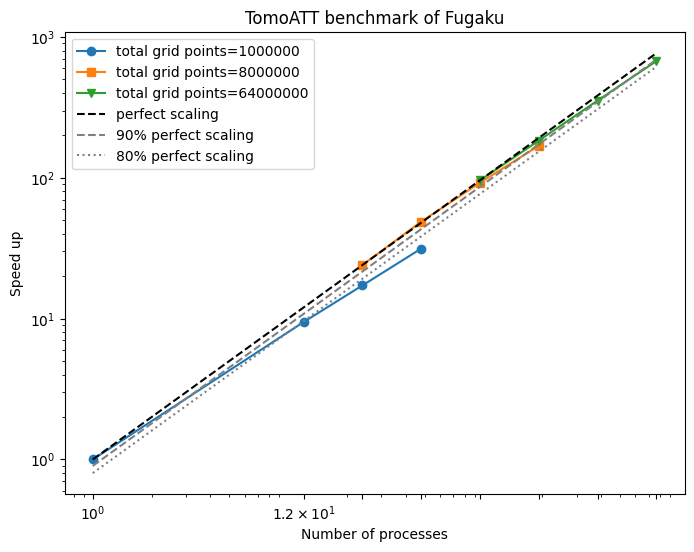

In [92]:
# read results from text_*.txt
import glob

n_grids = [100, 200, 400]

n_procs = [[1,12,24,48], # 1-4 nodes
           [24,48,96,192], # 2-16 nodes
           [96,192,384,768]] # 4-32 nodes

# calculate required nodes for each grid and n_procs
n_nodes = [[1,1,2,4],
           [2,4,8,16],
           [8,16,32,64]]

times = [[],[],[]]
spups = [[],[],[]]


path_dir = "./bench_fugaku"
for i, ngrid in enumerate(n_grids):
        for j, nproc in enumerate(n_procs[i]):
            nnode = n_nodes[i][j]
            n_sweep, ndiv_r, ndiv_t, ndiv_p = assign_procs(nproc, nnode)
 
            fname = path_dir + "/time_{0}-{0}-{0}_{1}-{2}-{3}-{4}.txt".format(ngrid, n_sweep, ndiv_r, ndiv_t, ndiv_p)
            print(fname)

            with open(fname, "r") as f:
                lines = f.readlines()
                line = lines[0]
                n_iters = int(line.split(',')[0].split(' ')[-1])
                l1 = float(line.split(',')[1].split(' ')[-1])
                linf = float(line.split(',')[2].split(' ')[-1])
                time = float(line.split(',')[3].split(' ')[-1])

                times[i].append(time)
                spups[i].append(1/(times[i][-1]/(times[i][0]*n_procs[i][0])))


import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

markers = ['o', 's', 'v', 'd', 'p', 'h', 'x', 'D', 'H', '8', 'P', 'X', 'd', 'p', 'h', 'x', 'D', 'H', '8', 'P', 'X']

# plot speed up
for i, ngrid in enumerate(n_grids):
    #print(n_procs[i])
    #print(times[i])
    ntotal = ngrid**3
    ax.plot(n_procs[i], spups[i], marker=markers[i], label="total grid points={0}".format(ntotal))

# log x 
ax.set_xscale('log')
# log y
ax.set_yscale('log')
# y axis title speed up
ax.set_ylabel("Speed up")
# x axis title number of processes
ax.set_xlabel("Number of processes")

nprocs_total = np.unique(np.array(n_procs).flatten())
#speedup_total = np.unique(np.array(spups).flatten())
# set ticks
ax.set_xticks(nprocs_total)
#ax.set_yticks(speedup_total)

# write perfect scaling
ax.plot(nprocs_total, nprocs_total, linestyle='dashed', color='black', label="perfect scaling")
# 90% perfect scaling
ax.plot(nprocs_total, nprocs_total*0.9, linestyle='dashed', color='gray', label="90% perfect scaling")
# 80% perfect scaling
ax.plot(nprocs_total, nprocs_total*0.8, linestyle=':', color='gray', label="80% perfect scaling")

# legend
ax.legend()

# title
ax.set_title("TomoATT benchmark of Fugaku")


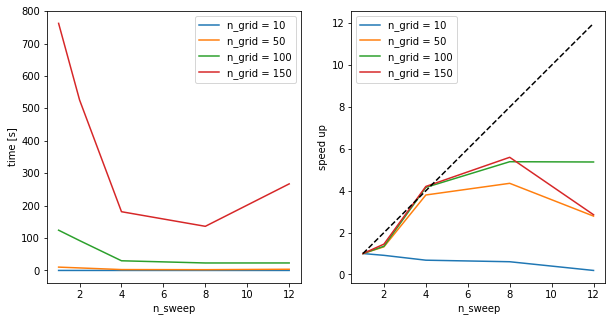

In [ ]:
# read time*.txt and plot

import numpy as np
import matplotlib.pyplot as plt
from natsort import natsortedn
 
 

# grep time_*.txt
import glob

def get_nsweep_and_time(num_ngrid, ndiv_p, ndiv_t, ndiv_r):

    #time_files = glob.glob('time_*.txt')
    time_files = glob.glob('time_{}-*_*-{}-{}-{}.txt'.format(num_ngrid, ndiv_p, ndiv_t, ndiv_r))
    time_files = natsorted(time_files)
    
    # read time*.txt and get parameter from filename
    n_grid = []
    n_sweep = []
    n_div   = []time_400-400-400_12-4-4-4.txt
    time = []
    for time_file in time_files:
        with open(time_file, 'r') as f:
            lines = f.readlines()
            time.append(float(lines[0].split(" ")[-1]))
        n_grid.append(int(time_file.split('_')[1].split('-')[0]))
        n_sweep.append(int(time_file.split('_')[2].split('-')[0]))
        ndiv_r = int(time_file.split('_')[2].split('-')[1])
        ndiv_t = int(time_file.split('_')[2].split('-')[2])
        ndiv_p = int(time_file.split('_')[2].split('-')[3].split(".")[0])

        n_div.append(ndiv_r * ndiv_t * ndiv_p)

    return n_sweep, n_div, time


nswp_10,  _, time_10 = get_nsweep_and_time(10  ,1,1,1)
nswp_50,  _, time_50 = get_nsweep_and_time(50  ,1,1,1)
nswp_100, _, time_100 = get_nsweep_and_time(100,1,1,1)
nswp_150, _, time_150 = get_nsweep_and_time(150,1,1,1)


# plot time and speed up
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(nswp_10,  np.array(time_10 ), label='n_grid = 10')
plt.plot(nswp_50,  np.array(time_50 ), label='n_grid = 50')
plt.plot(nswp_100, np.array(time_100), label='n_grid = 100')
plt.plot(nswp_150, np.array(time_150), label='n_grid = 150')
plt.xlabel('n_sweep')
plt.ylabel('time [s]')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(nswp_10, time_10[0]/np.array(time_10), label='n_grid = 10')
plt.plot(nswp_50, time_50[0]/np.array(time_50), label='n_grid = 50')
plt.plot(nswp_100, time_100[0]/np.array(time_100), label='n_grid = 100')
plt.plot(nswp_150, time_150[0]/np.array(time_150), label='n_grid = 150')
plt.xlabel('n_sweep')
plt.ylabel('speed up')

# write ideal
plt.plot(n_sweep, n_sweep, 'k--')

plt.legend()


['time_150-150-150_1-1-1-1.txt', 'time_150-150-150_1-2-1-1.txt', 'time_150-150-150_1-2-2-1.txt', 'time_150-150-150_1-2-2-2.txt', 'time_150-150-150_1-3-2-2.txt']


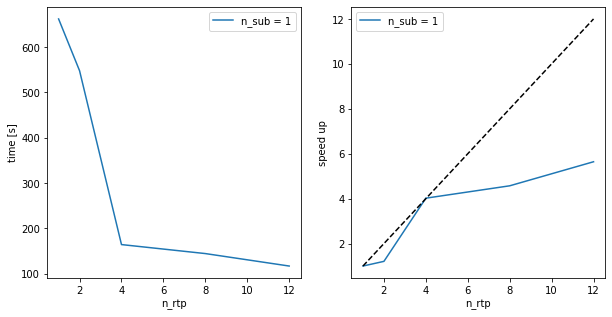

In [ ]:
def get_nsub_and_time(num_ngrid):

    #time_files = glob.glob('time_*.txt')
    time_files = glob.glob('time_{}-*_1-*.txt'.format(num_ngrid))
    time_files = natsorted(time_files)
    print(time_files)
    
    # read time*.txt and get parameter from filename
    n_grid = []
    n_sweep = []
    n_div   = []
    time = []
    for time_file in time_files:
        with open(time_file, 'r') as f:
            lines = f.readlines()
            time.append(float(lines[0].split(" ")[-1]))
        n_grid.append(int(time_file.split('_')[1].split('-')[0]))
        n_sweep.append(int(time_file.split('_')[2].split('-')[0]))
        ndiv_r = int(time_file.split('_')[2].split('-')[1])
        ndiv_t = int(time_file.split('_')[2].split('-')[2])
        ndiv_p = int(time_file.split('_')[2].split('-')[3].split(".")[0])

        n_div.append(ndiv_r * ndiv_t * ndiv_p)

    return n_sweep, n_div, time




_, nsub_1, time_1 = get_nsub_and_time(150)
#_, nsub_2, time_2 = get_nsweep_and_time(150,2,1,1)
#_, nsub_4, time_4 = get_nsweep_and_time(150,2,2,1)
#_, nsub_8, time_8 = get_nsweep_and_time(150,2,2,2)
#_, nsub_12,time_12= get_nsweep_and_time(150,3,2,2)

# plot time and speed up
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(nsub_1,  np.array(time_1 ), label='n_sub = 1')
#plt.plot(nsub_2,  np.array(time_2 ), label='n_sub = 2')
#plt.plot(nsub_4,  np.array(time_4 ), label='n_sub = 4')
#plt.plot(nsub_8,  np.array(time_8 ), label='n_sub = 8')
#plt.plot(nsub_12, np.array(time_12), label='n_sub = 12')
plt.xlabel('n_rtp')
plt.ylabel ('time [s]')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(nsub_1, time_1[0]/np.array(time_1), label='n_sub = 1')
#plt.plot(nsub_2, time_2[0]/np.array(time_2), label='n_sub = 2')
#plt.plot(nsub_4, time_4[0]/np.array(time_4), label='n_sub = 4')
#plt.plot(nsub_8, time_8[0]/np.array(time_8), label='n_sub = 8')
#plt.plot(nsub_12, time_12[0]/np.array(time_12), label='n_sub = 12')
plt.xlabel('n_rtp')
plt.ylabel('speed up')

# write ideal
plt.plot(nsub_1, nsub_1, 'k--')

plt.legend()



In [ ]:
nsub_2

[2]